# Código Clasificación buques mercantes utilizando CNN.
Cristóbal Balmelli

## Cargamos las librerias necesarias

In [1]:
import numpy as np
import os
import re #desconozco esta librería
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras_layer_normalization import LayerNormalization
from tensorflow.keras.activations import relu
from PIL import Image
import imghdr #verificar porque es deprecated
import seaborn as sns #Borrar
from keras.preprocessing.image import ImageDataGenerator

C:\Users\cbalm\AppData\Local\Temp\ipykernel_32520\1467697216.py:17: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## Cargamos las imagenes

In [2]:
dirname = os.path.join(os.getcwd(), 'datos')
imgpath = dirname + os.sep 

altura,longitud=100,100 #tamaño pixeles de las imagenes... OJO CON LA CANTIDAD DE PIXELES

directories = []
dircount = []
prevRoot=''
cant=0
 
print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

def cargar_y_redimensionar_imagenes(ruta):
    imagenes_redimensionadas = []
    for archivo in os.listdir(ruta):
        # Verificamos si el archivo es una imagen válida antes de abrirlo
        tipo_imagen = imghdr.what(os.path.join(ruta, archivo))
        if tipo_imagen in ['jpeg', 'png', 'bmp', 'gif']:
            imagen = Image.open(os.path.join(ruta, archivo))
            imagen = imagen.resize((altura, longitud))
            imagen_array = np.array(imagen)
            # Verificamos que la imagen tenga 3 canales (RGB) antes de agregarla
            if len(imagen_array.shape) == 3 and imagen_array.shape[2] == 3:
                imagenes_redimensionadas.append(imagen_array)
    return imagenes_redimensionadas

# Rutas de los directorios de imágenes
ruta_mercantes = './datos/mercantes'
ruta_otros = './datos/otros'

# Cargar y redimensionar imágenes de mercantes y otros
imagenes_mercantes = cargar_y_redimensionar_imagenes(ruta_mercantes)
imagenes_otros = cargar_y_redimensionar_imagenes(ruta_otros)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  c:\Users\cbalm\iCloudDrive\APN\Tesis\Codigo\datos\
c:\Users\cbalm\iCloudDrive\APN\Tesis\Codigo\datos\mercantes 1
c:\Users\cbalm\iCloudDrive\APN\Tesis\Codigo\datos\otros 54
Directorios leidos: 2
Imagenes en cada directorio [55, 41]
suma Total de imagenes en subdirs: 96


## Crear etiquetas y clases

Creamos los labels con valor 0 para mercante y 1 para otros. 

In [3]:
# Crear una lista de etiquetas (0 para mercantes, 1 para otros)
etiquetas_mercantes = [0] * len(imagenes_mercantes)
etiquetas_otros = [1] * len(imagenes_otros)

# Combinar las imágenes y etiquetas en un solo conjunto de datos
imagenes = imagenes_mercantes + imagenes_otros
etiquetas = etiquetas_mercantes + etiquetas_otros

## Creamos sets de Entrenamiento y Test

In [4]:

# Convertir a arreglos NumPy
X = np.array(imagenes, dtype=np.uint8)
y = np.array(etiquetas)

# Dividir los datos en conjuntos de entrenamiento y validación (80% para entrenamiento, 20% para validación)
train_X, valid_X, train_label, valid_label = train_test_split(X, y, test_size=0.2, random_state=42)

train_X = train_X / 255.
valid_X = valid_X / 255.

# Find the unique numbers from the train labels
classes = np.unique(train_label)
nClasses = len(classes)
print('Total number of outputs:', nClasses)
print('Output classes:', classes)

train_label_one_hot = to_categorical(train_label, num_classes=nClasses)
valid_label_one_hot = to_categorical(valid_label, num_classes=nClasses)

Total number of outputs: 2
Output classes: [0 1]


## Data augmentation

In [7]:
# Configurar las transformaciones de data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,         # Rango de rotación aleatoria (en grados)
    width_shift_range=0.2,     # Rango de traslación horizontal aleatoria (como fracción del ancho total)
    height_shift_range=0.2,    # Rango de traslación vertical aleatoria (como fracción del alto total)
    shear_range=0.2,           # Rango de cizallamiento (shear) aleatorio
    zoom_range=0.2,            # Rango de zoom aleatorio
    horizontal_flip=True,      # Volteo horizontal aleatorio
    fill_mode='nearest'        # Modo de rellenado para las transformaciones
)



## Creamos la red neuronal

In [8]:
INIT_LR = 0.0005#1e-3

filtrosConv1=32 #despoues de la 1ra conv, la imagen va a tener prof de 32
filtrosConv2=64 #despjes de la 2da, tendra 64
tamano_filtro1=(3,3)
tamano_filtro2=(2,2)
tamano_pool=(2,2)

modelo = Sequential()
modelo.add(Convolution2D(filtrosConv1, tamano_filtro1, padding='same', input_shape=(altura,longitud,3),activation='relu'))
modelo.add(MaxPooling2D(pool_size=tamano_pool))

#segunda capa de convolucion (), seguida de una capa de max pooling
modelo.add(Convolution2D(filtrosConv2, tamano_filtro2, padding='same', activation='relu'))
modelo.add(MaxPooling2D(pool_size=tamano_pool))

#capa que aplana la imagen (1D)
modelo.add(Flatten())

#capa normal, de 256 neuronas
modelo.add(Dense(256,activation='relu'))

#capa que apagara el 50% de las neuronas en cada paso, para evitar el overfitting
modelo.add(Dropout(0.5))

#ultima capa, que son 2 neuronas (una por clase) donde dara % prob da cada clase
modelo.add(Dense(nClasses,activation='softmax'))

modelo.summary()

modelo.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        8256      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 40000)             0         
                                                                 
 dense_2 (Dense)             (None, 256)              

## Entrenamos la red
Con los datos de data augmentation

In [9]:
epochs = 10
batch_size = 64

# Crear el generador de datos para el conjunto de entrenamiento con data augmentation
train_data_generator = data_augmentation.flow(train_X, train_label_one_hot, batch_size=batch_size)

history=modelo.fit(train_X, train_label_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label_one_hot))
 
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
dir='./modelo/'

if not os.path.exists(dir):
    os.mkdir(dir)
modelo.save('./modelo/modelo.h5')
modelo.save_weights('./modelo/pesos.h5')

Epoch 1/10
2/2 [==============================] - 4s 648ms/step - loss: 0.6938 - accuracy: 0.5526 - val_loss: 0.6650 - val_accuracy: 0.6842
Epoch 2/10
2/2 [==============================] - 1s 290ms/step - loss: 0.9979 - accuracy: 0.5263 - val_loss: 0.6976 - val_accuracy: 0.5263
Epoch 3/10
2/2 [==============================] - 1s 283ms/step - loss: 0.6495 - accuracy: 0.6316 - val_loss: 0.7538 - val_accuracy: 0.3158
Epoch 4/10
2/2 [==============================] - 1s 316ms/step - loss: 0.6429 - accuracy: 0.5000 - val_loss: 0.6047 - val_accuracy: 0.7368
Epoch 5/10
2/2 [==============================] - 1s 285ms/step - loss: 0.5965 - accuracy: 0.6579 - val_loss: 0.5693 - val_accuracy: 0.6842
Epoch 6/10
2/2 [==============================] - 1s 286ms/step - loss: 0.6136 - accuracy: 0.6447 - val_loss: 0.5575 - val_accuracy: 0.7368
Epoch 7/10
2/2 [==============================] - 1s 336ms/step - loss: 0.5318 - accuracy: 0.7105 - val_loss: 0.5755 - val_accuracy: 0.7368
Epoch 8/10
2/2 [====

C:\Users\cbalm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Obtenemos las métricas de entrenamiento y validación, luego graficamos

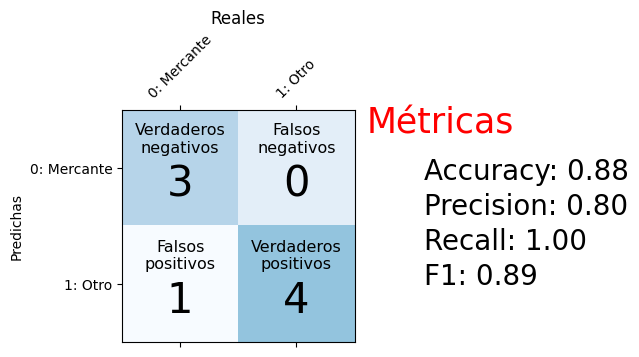

In [11]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def metricas(clases_reales, clases_predichas):
    matriz_conf=confusion_matrix(clases_reales, clases_predichas)
    accuracy=accuracy_score(clases_reales,clases_predichas)
    precision=precision_score(clases_reales,clases_predichas)
    recall=recall_score(clases_reales,clases_predichas)
    f1=f1_score(clases_reales,clases_predichas)
    return matriz_conf, accuracy, recall, precision, f1

def visualizar_metricas(clases_reales,clases_predichas, titulo):
    #Calculamos metricas con la funcion previa
    matriz, accuracy, recall, precision, f1=metricas(clases_reales,clases_predichas)

    #Graficamos
    plt.figure(figsize=(3,3))
    matriz=pd.DataFrame(matriz,columns=['0: Mercante', '1: Otro'])
    plt.matshow(matriz, cmap="Blues", vmin=0, vmax=10, fignum=1)
    plt.title("Reales")
    plt.ylabel("Predichas")
    plt.xticks(range(len(matriz.columns)), matriz.columns, rotation=45)
    plt.yticks(range(len(matriz.columns)), matriz.columns)
    etiquetas = (("Verdaderos\nnegativos", "Falsos\npositivos"),
                 ("Falsos\nnegativos", "Verdaderos\npositivos"))
    for i in range(len(matriz.columns)):
        for j in range(len(matriz.columns)):
            plt.text(i, j + 0.14, str(matriz.iloc[i, j]),
                     fontsize=30, ha="center", va="center")
            plt.text(i, j - 0.25, etiquetas[i][j],
                     fontsize=11.5, ha="center", va="center")           
    plt.text(1.60, -0.30, titulo, fontsize=25, c="red")
    plt.text(2.1, 0.10, "Accuracy: %0.2f" % accuracy, fontsize=20)
    plt.text(2.1, 0.40, "Precision: %0.2f" % precision, fontsize=20)
    plt.text(2.1, 0.70, "Recall: %0.2f" % recall, fontsize=20)
    plt.text(2.1, 1.00, "F1: %0.2f" % f1, fontsize=20)    
    plt.show()
    print("\n")

print("\n")

reales=[1,1,0,0,0,0,1,1]
predichas=[1,1,0,0,0,1,1,1]

visualizar_metricas(reales,predichas,'Métricas')

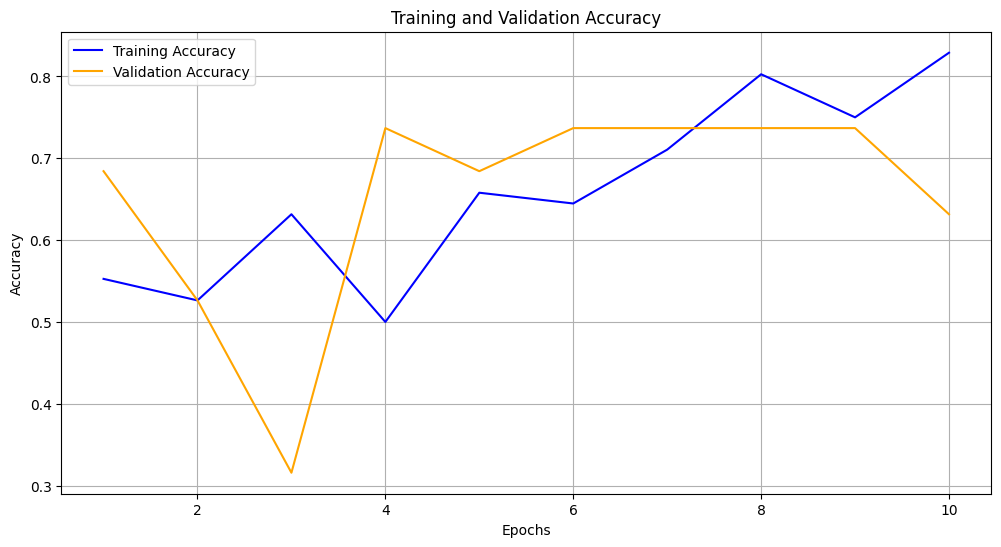

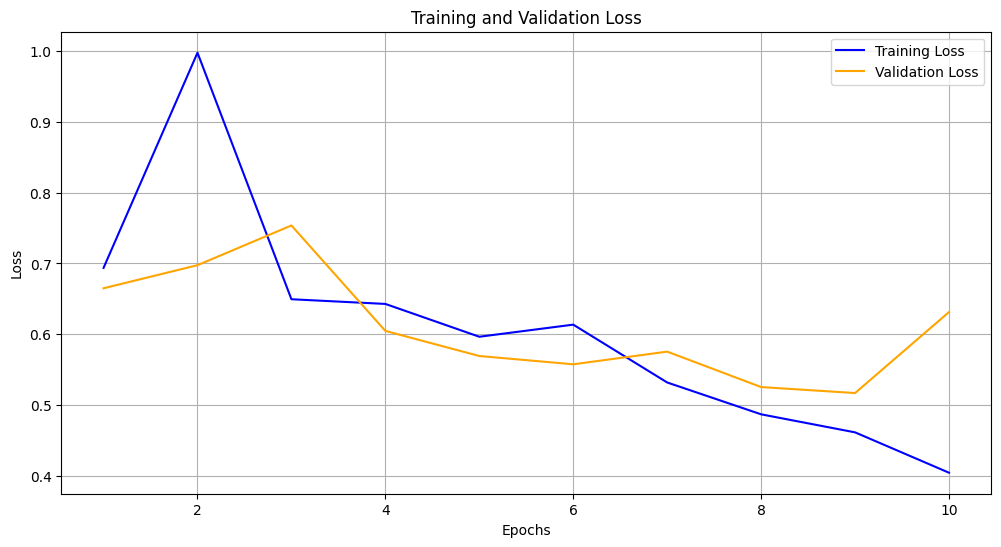

In [12]:
# Obtener las métricas de entrenamiento y validación
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, epochs + 1)

# Gráfica de precisión (accuracy)
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de pérdida (loss)
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Probamos la red

In [13]:
from keras.preprocessing import image
import numpy as np

directorio_imagen_prueba='./prueba/7.jpg'
# Carga la imagen de prueba
imagen_prueba = image.load_img(directorio_imagen_prueba, target_size=(100, 100))
imagen_prueba = image.img_to_array(imagen_prueba)

# Normaliza la imagen (importante para tener los mismos preprocesamientos que las imágenes de entrenamiento y validación)
imagen_prueba = imagen_prueba / 255.0

# Ajusta las dimensiones de la imagen para que sea compatible con la entrada del modelo
imagen_prueba = np.expand_dims(imagen_prueba, axis=0)

# Obtén las predicciones utilizando el modelo entrenado
predicciones = modelo.predict(imagen_prueba)

# Las predicciones son un arreglo de probabilidades, conviértelas a una clase
clase_predicha = np.argmax(predicciones[0])

# Obten la clase correspondiente al índice
clase = classes[clase_predicha]

# Obten el porcentaje de confianza para la clase predicha
porcentaje_confianza = predicciones[0][clase_predicha] * 100

image.load_img(directorio_imagen_prueba).show()
print("La imagen es de clase:", clase)
print("Porcentaje de confianza:", porcentaje_confianza, "%")

1/1 [==============================] - 0s 204ms/step
La imagen es de clase: 1
Porcentaje de confianza: 98.83805513381958 %


In [14]:
def prueba_modelo(modelo, directorio, altura, longitud, classes):
    resultados = []
    for archivo in os.listdir(directorio):
        ruta_imagen = os.path.join(directorio, archivo)
        # Carga la imagen de prueba
        imagen_prueba = image.load_img(ruta_imagen, target_size=(altura, longitud))
        imagen_prueba = image.img_to_array(imagen_prueba)

        # Normaliza la imagen (importante para tener los mismos preprocesamientos que las imágenes de entrenamiento y validación)
        imagen_prueba = imagen_prueba / 255.0

        # Ajusta las dimensiones de la imagen para que sea compatible con la entrada del modelo
        imagen_prueba = np.expand_dims(imagen_prueba, axis=0)

        # Obtén las predicciones utilizando el modelo entrenado
        predicciones = modelo.predict(imagen_prueba)

        # Las predicciones son un arreglo de probabilidades, conviértelas a una clase
        clase_predicha = np.argmax(predicciones[0])

        # Obten la clase correspondiente al índice
        clase = classes[clase_predicha]

        resultados.append((archivo, clase))

    return resultados

# Uso de la función prueba_modelo
directorio_imagenes = './prueba'
resultados = prueba_modelo(modelo, directorio_imagenes, altura, longitud, classes)

# Mostrar resultados
for archivo, clase in resultados:
    print(f"La imagen {archivo} es de clase: {clase}")

1/1 [==============================] - 0s 36ms/step
La imagen 1.jpg es de clase: 1
La imagen 2.png es de clase: 1
La imagen 3.jpg es de clase: 0
La imagen 4.jpg es de clase: 0
La imagen 5.jpg es de clase: 0
La imagen 6.jpg es de clase: 1
La imagen 7.jpg es de clase: 1
La imagen 8.jpg es de clase: 1
